<a href="https://colab.research.google.com/github/IMOKURI/wandb-demo/blob/main/WandB_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📔 About this notebook

## 📝 Memo

# Prepare for Kaggle

- Add dataset [imokuri/wandbtoken](https://www.kaggle.com/imokuri/wandbtoken)

# Prepare for Colab

In [1]:
!nvidia-smi

Fri Sep 10 08:03:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    42W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import zipfile

if os.path.exists('init.txt'):
    print("Already initialized.")

else:
    if 'google.colab' in sys.modules:
        from google.colab import drive
        drive.mount('/content/drive')
        dataset_dir = "/content/drive/MyDrive/Datasets"

        with zipfile.ZipFile(f"{dataset_dir}/cassava-leaf-disease-classification-2021.zip", "r") as zp:
            zp.extractall(path="./")

    # for StratifiedGroupKFold
    # !pip uninstall -y scikit-learn
    # !pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

    # for MultilabelStratifiedKFold
    # !pip install -q iterative-stratification

    # for CosineAnnealingWarmupRestarts
    # !pip install -qU 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

    !pip install -q wandb
    # !pip install -q optuna

    # ====================================================
    # Competition specific libraries
    # ====================================================
    !pip install -q timm
    !pip install -q albumentations==0.4.6

    !touch init.txt

Already initialized.


# 📚 Library

In [3]:
# General libraries
import collections
import glob
import json
import math
import os
import random
import re
import statistics
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import wandb
# from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold  # , StratifiedGroupKFold
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [4]:
# Competition specific libraries
import albumentations as A
import cv2
import timm
from albumentations.pytorch import ToTensorV2

In [5]:
warnings.filterwarnings("ignore")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
netrc = "/content/drive/MyDrive/.netrc" if 'google.colab' in sys.modules else "../input/wandbtoken/.netrc"
!cp -f {netrc} ~/
!wandb login

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


# Load Data

In [8]:
DATA_DIR = "./" if 'google.colab' in sys.modules else "../input/xxx/"
OUTPUT_DIR = "./"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [9]:
train = pd.read_csv(DATA_DIR + "train.csv")
# test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submission.csv")

TRAIN_IMAGE_PATH = DATA_DIR + "train_images/"
TEST_IMAGE_PATH = DATA_DIR + "test_images/"

# Config

In [10]:
# seed = random.randrange(10000)
seed = 440
print(seed)

440


In [11]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "baseline"
    print_freq = 100

    train = True
    validate = False
    inference = False

    sweep = False
    sweep_count = 5

    debug = True
    num_debug_data = 1000

    amp = True
    amp_opt_level = "O1"

In [12]:
config_defaults = {
    "seed": seed,
    "n_class": 5,
    "n_fold": 5,
    "epochs": 10,
    "batch_size": 8,
    "gradient_accumulation_steps": 2,
    "max_grad_norm": 1000,
    "criterion": "CrossEntropyLoss",
    "optimizer": "Adam",
    "scheduler": "CosineAnnealingWarmRestarts",
    "lr": 1e-4,
    "min_lr": 5e-6,
    "weight_decay": 1e-6,
    "model_name": "resnext50_32x4d", # "vit_base_patch16_384",
    "size": 512,
}

In [13]:
config_sweep = {
    "method": "grid",
    "metric": {
        "name": "loss",
        "goal": "minimize",
    },
    "parameters": {
        "seed": {"value": config_defaults["seed"]},
        "n_class": {"value": config_defaults["n_class"]},
        "n_fold": {"value": config_defaults["n_fold"]},
        "batch_size": {"value": config_defaults["batch_size"]},
        "gradient_accumulation_steps": {"value": config_defaults["gradient_accumulation_steps"]},
        "max_grad_norm": {"value": config_defaults["max_grad_norm"]},
        "criterion": {"value": config_defaults["criterion"]},
        "optimizer": {"value": config_defaults["optimizer"]},
        "scheduler": {"value": config_defaults["scheduler"]},
        "lr": {"value": config_defaults["lr"]},
        "min_lr": {"value": config_defaults["min_lr"]},
        "weight_decay": {"value": config_defaults["weight_decay"]},
        "model_name": {"value": config_defaults["model_name"]},
        "size": {"value": config_defaults["size"]},
    },
}

In [14]:
num_data = Config.num_debug_data if Config.debug else len(train)
num_steps = num_data // config_defaults["n_fold"] * (config_defaults["n_fold"] - 1) \
    // config_defaults["batch_size"] // config_defaults["gradient_accumulation_steps"] \
    * config_defaults["epochs"]
print(num_steps)

# TODO: config_sweep にも追加
if config_defaults["scheduler"] == "CosineAnnealingWarmRestarts":
    config_defaults["T_0"] = num_steps

elif config_defaults["scheduler"] == "CosineAnnealingLR":
    config_defaults["T_max"] = num_steps

elif config_defaults["scheduler"] == "CosineAnnealingWarmupRestarts":
    config_defaults["first_cycle_steps"] = num_steps
    config_defaults["warmup_steps"] = num_steps // 10

500


In [15]:
if Config.debug:
    config_defaults["epochs"] = 1
    Config.print_freq = 10
    Config.sweep_count = 1

In [16]:
if Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

else:
    wandb_job_type = ""

In [17]:
if Config.debug or Config.sweep:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        mode="disabled",
    )
else:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        job_type=wandb_job_type,
        save_code=True,
    )

In [18]:
config = wandb.config

# EDA 1

In [19]:
# for df in [train, test, sub]:
for df in [train, sub]:
    print(f"=" * 120)
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1 non-null      object
 1   label     1 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 144.0+ bytes


,image_id,label
0,2216849948.jpg,4


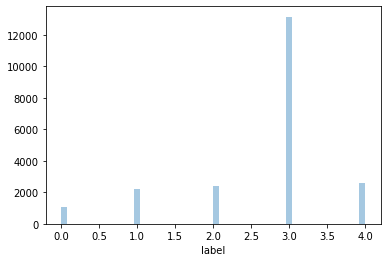

In [20]:
sns.distplot(train["label"], kde=False)

# Preprocess

In [21]:
def get_transforms(*, data):
    if data == "train":
        return A.Compose(
            [
                # A.Resize(config.size, config.size),
                A.RandomResizedCrop(config.size, config.size),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return A.Compose(
            [
                A.Resize(config.size, config.size),
                A.CenterCrop(config.size, config.size),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

# EDA 2

# 👑 Load Artifacts

In [22]:
if Config.debug:
    train = train.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
    if len(sub) > Config.num_debug_data:
        # test = test.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
        sub = sub.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)

# Make Fold

In [23]:
Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["label"])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.int8)
print(train.groupby(["fold", "label"]).size())

fold  label
0     0         10
      1         21
      2         22
      3        125
      4         22
1     0         10
      1         21
      2         22
      3        125
      4         22
2     0         10
      1         21
      2         22
      3        124
      4         23
3     0         10
      1         21
      2         21
      3        125
      4         23
4     0         10
      1         21
      2         21
      3        125
      4         23
dtype: int64


# Utils

In [24]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)

# Dataset

In [25]:
class BaseDataset(Dataset):
    def __init__(self, df, transform=None, label=True):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

        self.use_label = label
        if self.use_label:
            self.path = TRAIN_IMAGE_PATH
            self.labels = df["label"].values
        else:
            self.path = TEST_IMAGE_PATH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{self.path}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        if self.use_label:
            label = torch.tensor(self.labels[idx])
            return image, label
        return image

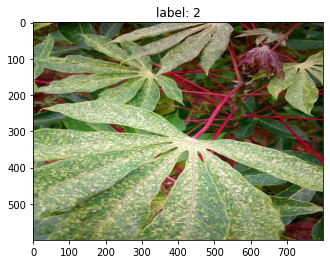

In [26]:
train_ds = BaseDataset(train)
image, label = train_ds[0]
plt.imshow(image)
plt.title(f"label: {label}")
plt.show()

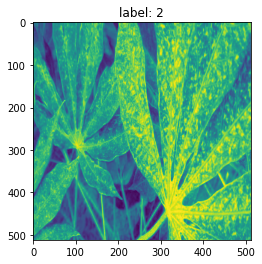

In [27]:
train_ds = BaseDataset(train, transform=get_transforms(data="train"))
image, label = train_ds[0]
plt.imshow(image[0])
plt.title(f"label: {label}")
plt.show()

# 🚗 Model

In [28]:
class BaseModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, config.n_class)

        elif model_name.startswith("tf_efficientnet"):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, config.n_class)

        elif model_name.startswith("vit_"):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, config.n_class)

    def forward(self, x):
        x = self.model(x)
        return x

In [29]:
if config.model_name != "":
    model = BaseModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, label in train_loader:
        output = model(image)
        print(output)
        break

BaseModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

# Optimizer

# Loss

# Scoring

In [30]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [31]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["label"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    if fold == config.n_fold:
        wandb.log({"CV": score})
    else:
        wandb.log({f"CV_fold{fold}": score})

# Helper functions

In [32]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [33]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device):
    losses = AverageMeter()

    # switch to train mode
    model.train()
    start = time.time()
    optimizer.zero_grad()

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with amp.autocast(enabled=Config.amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            loss = loss / config.gradient_accumulation_steps
            
        scaler.scale(loss).backward()

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()
            optimizer.zero_grad()

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"LR: {scheduler.get_lr()[0]:.6f}  "
            )

    return losses.avg

In [34]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        preds.append(y_preds.softmax(1).to("cpu").numpy())
        # preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Postprocess

# 🏃‍♂️ Train loop

In [35]:
def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="train"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "AdamW":
            optimizer = T.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=config.T_0, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=config.T_max, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer, first_cycle_steps=config.first_cycle_steps, max_lr=config.lr, min_lr=config.min_lr, warmup_steps=config.warmup_steps
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    model.to(device)

    optimizer = get_optimizer(model)
    scaler = amp.GradScaler(enabled=Config.amp)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()

        return criterion

    criterion = get_criterion()

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf
    best_preds = None

    for epoch in range(config.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["label"].values

        # if config.criterion == "BCEWithLogitsLoss":
        #     preds = 1 / (1 + np.exp(-preds))

        # scoring
        score = get_score(valid_labels, preds.argmax(1))
        # score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s")
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log({
            "epoch": epoch + 1,
            f"loss/train_fold{fold}": avg_loss,
            f"loss/valid_fold{fold}": avg_val_loss,
            f"score/fold{fold}": score,
        })

        if avg_val_loss < best_loss:
            best_score = score
            best_loss = avg_val_loss
            best_preds = preds
            LOGGER.info(f"Epoch {epoch+1} - Save Best Model. score: {best_score:.4f}, loss: {best_loss:.4f}")

            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth"
            )
            wandb.save(OUTPUT_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth")

    valid_folds[[str(c) for c in range(config.n_class)]] = best_preds
    valid_folds["preds"] = best_preds.argmax(1)
    # valid_folds["preds"] = best_preds

    return valid_folds, best_score, best_loss

# Main function

In [36]:
def main():
    # ====================================================
    # Training
    # ====================================================
    if Config.train:
        oof_df = pd.DataFrame()
        oof_result = []
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df, score, loss = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            oof_result.append([fold, score, loss])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)
            
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        loss = statistics.mean([d[2] for d in oof_result])
        wandb.log({"loss": loss})

        table = wandb.Table(data=oof_result, columns = ["fold", "score", "loss"])
        run.log({"Fold Result": table})
        
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

# 🧹 Sweep

In [36]:
if Config.sweep:
    sweep_id = wandb.sweep(config_sweep, entity=Config.wandb_entity, project=Config.wandb_project)
    wandb.agent(sweep_id, main, count=Config.sweep_count)

# 🚀 Run

In [37]:
if not Config.sweep:
    main()

========== fold: 0 training ==========


Epoch: [1][0/100] Elapsed 0m 0s (remain 1m 38s) Loss: 1.6034 LR: 0.000100  
Epoch: [1][10/100] Elapsed 0m 4s (remain 0m 34s) Loss: 1.5011 LR: 0.000100  
Epoch: [1][20/100] Elapsed 0m 7s (remain 0m 27s) Loss: 1.3939 LR: 0.000100  
Epoch: [1][30/100] Elapsed 0m 10s (remain 0m 23s) Loss: 1.2949 LR: 0.000100  
Epoch: [1][40/100] Elapsed 0m 13s (remain 0m 19s) Loss: 1.1991 LR: 0.000100  
Epoch: [1][50/100] Elapsed 0m 16s (remain 0m 16s) Loss: 1.1227 LR: 0.000099  
Epoch: [1][60/100] Elapsed 0m 19s (remain 0m 12s) Loss: 1.1299 LR: 0.000099  
Epoch: [1][70/100] Elapsed 0m 23s (remain 0m 9s) Loss: 1.0790 LR: 0.000099  
Epoch: [1][80/100] Elapsed 0m 26s (remain 0m 6s) Loss: 1.0623 LR: 0.000099  
Epoch: [1][90/100] Elapsed 0m 29s (remain 0m 2s) Loss: 1.0353 LR: 0.000098  
Epoch: [1][99/100] Elapsed 0m 32s (remain 0m 0s) Loss: 1.0091 LR: 0.000098  
EVAL: [0/25] Elapsed 0m 0s (remain 0m 20s) Loss: 0.5025 
EVAL: [10/25] Elapsed 0m 1s (remain 0m 2s) Loss: 0.8616 
EVAL: [20/25] Elapsed 0m 2s (remain 

Epoch 1 - avg_train_loss: 1.0091  avg_val_loss: 0.8057  time: 36s
Epoch 1 - Score: 0.675
Epoch 1 - Save Best Model. score: 0.6750, loss: 0.8057


EVAL: [24/25] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8057 


========== fold: 0 result ==========
Score: 0.67500
========== fold: 1 training ==========


Epoch: [1][0/100] Elapsed 0m 0s (remain 1m 36s) Loss: 1.7001 LR: 0.000100  
Epoch: [1][10/100] Elapsed 0m 4s (remain 0m 33s) Loss: 1.5297 LR: 0.000100  
Epoch: [1][20/100] Elapsed 0m 7s (remain 0m 27s) Loss: 1.3857 LR: 0.000100  
Epoch: [1][30/100] Elapsed 0m 10s (remain 0m 23s) Loss: 1.3031 LR: 0.000100  
Epoch: [1][40/100] Elapsed 0m 13s (remain 0m 19s) Loss: 1.2494 LR: 0.000100  
Epoch: [1][50/100] Elapsed 0m 16s (remain 0m 16s) Loss: 1.1697 LR: 0.000099  
Epoch: [1][60/100] Elapsed 0m 19s (remain 0m 12s) Loss: 1.1101 LR: 0.000099  
Epoch: [1][70/100] Elapsed 0m 23s (remain 0m 9s) Loss: 1.0683 LR: 0.000099  
Epoch: [1][80/100] Elapsed 0m 26s (remain 0m 6s) Loss: 1.0317 LR: 0.000099  
Epoch: [1][90/100] Elapsed 0m 29s (remain 0m 2s) Loss: 1.0425 LR: 0.000098  
Epoch: [1][99/100] Elapsed 0m 32s (remain 0m 0s) Loss: 1.0133 LR: 0.000098  
EVAL: [0/25] Elapsed 0m 0s (remain 0m 16s) Loss: 0.9064 
EVAL: [10/25] Elapsed 0m 1s (remain 0m 2s) Loss: 1.0075 
EVAL: [20/25] Elapsed 0m 2s (remain 

Epoch 1 - avg_train_loss: 1.0133  avg_val_loss: 1.0223  time: 36s
Epoch 1 - Score: 0.68
Epoch 1 - Save Best Model. score: 0.6800, loss: 1.0223


EVAL: [24/25] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0223 


========== fold: 1 result ==========
Score: 0.68000
========== fold: 2 training ==========


Epoch: [1][0/100] Elapsed 0m 0s (remain 1m 28s) Loss: 1.6647 LR: 0.000100  
Epoch: [1][10/100] Elapsed 0m 4s (remain 0m 32s) Loss: 1.4636 LR: 0.000100  
Epoch: [1][20/100] Elapsed 0m 7s (remain 0m 27s) Loss: 1.3193 LR: 0.000100  
Epoch: [1][30/100] Elapsed 0m 10s (remain 0m 23s) Loss: 1.2196 LR: 0.000100  
Epoch: [1][40/100] Elapsed 0m 13s (remain 0m 19s) Loss: 1.1712 LR: 0.000100  
Epoch: [1][50/100] Elapsed 0m 16s (remain 0m 15s) Loss: 1.1174 LR: 0.000099  
Epoch: [1][60/100] Elapsed 0m 19s (remain 0m 12s) Loss: 1.0982 LR: 0.000099  
Epoch: [1][70/100] Elapsed 0m 22s (remain 0m 9s) Loss: 1.0825 LR: 0.000099  
Epoch: [1][80/100] Elapsed 0m 26s (remain 0m 6s) Loss: 1.0622 LR: 0.000099  
Epoch: [1][90/100] Elapsed 0m 29s (remain 0m 2s) Loss: 1.0430 LR: 0.000098  
Epoch: [1][99/100] Elapsed 0m 32s (remain 0m 0s) Loss: 1.0255 LR: 0.000098  
EVAL: [0/25] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1631 
EVAL: [10/25] Elapsed 0m 1s (remain 0m 2s) Loss: 0.8630 
EVAL: [20/25] Elapsed 0m 2s (remain 

Epoch 1 - avg_train_loss: 1.0255  avg_val_loss: 1.0044  time: 36s
Epoch 1 - Score: 0.665
Epoch 1 - Save Best Model. score: 0.6650, loss: 1.0044


EVAL: [24/25] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0044 


========== fold: 2 result ==========
Score: 0.66500
========== fold: 3 training ==========


Epoch: [1][0/100] Elapsed 0m 0s (remain 1m 24s) Loss: 1.6914 LR: 0.000100  
Epoch: [1][10/100] Elapsed 0m 3s (remain 0m 32s) Loss: 1.5604 LR: 0.000100  
Epoch: [1][20/100] Elapsed 0m 7s (remain 0m 26s) Loss: 1.4299 LR: 0.000100  
Epoch: [1][30/100] Elapsed 0m 10s (remain 0m 22s) Loss: 1.2800 LR: 0.000100  
Epoch: [1][40/100] Elapsed 0m 13s (remain 0m 19s) Loss: 1.1875 LR: 0.000100  
Epoch: [1][50/100] Elapsed 0m 16s (remain 0m 15s) Loss: 1.1291 LR: 0.000099  
Epoch: [1][60/100] Elapsed 0m 19s (remain 0m 12s) Loss: 1.0960 LR: 0.000099  
Epoch: [1][70/100] Elapsed 0m 22s (remain 0m 9s) Loss: 1.0865 LR: 0.000099  
Epoch: [1][80/100] Elapsed 0m 26s (remain 0m 6s) Loss: 1.0646 LR: 0.000099  
Epoch: [1][90/100] Elapsed 0m 29s (remain 0m 2s) Loss: 1.0586 LR: 0.000098  
Epoch: [1][99/100] Elapsed 0m 32s (remain 0m 0s) Loss: 1.0410 LR: 0.000098  
EVAL: [0/25] Elapsed 0m 0s (remain 0m 14s) Loss: 0.9920 
EVAL: [10/25] Elapsed 0m 1s (remain 0m 2s) Loss: 0.9572 
EVAL: [20/25] Elapsed 0m 2s (remain 

Epoch 1 - avg_train_loss: 1.0410  avg_val_loss: 1.0469  time: 36s
Epoch 1 - Score: 0.56
Epoch 1 - Save Best Model. score: 0.5600, loss: 1.0469


EVAL: [24/25] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0469 


========== fold: 3 result ==========
Score: 0.56000
========== fold: 4 training ==========


Epoch: [1][0/100] Elapsed 0m 0s (remain 1m 35s) Loss: 1.6617 LR: 0.000100  
Epoch: [1][10/100] Elapsed 0m 4s (remain 0m 32s) Loss: 1.5484 LR: 0.000100  
Epoch: [1][20/100] Elapsed 0m 7s (remain 0m 27s) Loss: 1.4050 LR: 0.000100  
Epoch: [1][30/100] Elapsed 0m 10s (remain 0m 23s) Loss: 1.2778 LR: 0.000100  
Epoch: [1][40/100] Elapsed 0m 13s (remain 0m 19s) Loss: 1.2230 LR: 0.000100  
Epoch: [1][50/100] Elapsed 0m 16s (remain 0m 15s) Loss: 1.2026 LR: 0.000099  
Epoch: [1][60/100] Elapsed 0m 19s (remain 0m 12s) Loss: 1.1566 LR: 0.000099  
Epoch: [1][70/100] Elapsed 0m 22s (remain 0m 9s) Loss: 1.1304 LR: 0.000099  
Epoch: [1][80/100] Elapsed 0m 26s (remain 0m 6s) Loss: 1.0987 LR: 0.000099  
Epoch: [1][90/100] Elapsed 0m 29s (remain 0m 2s) Loss: 1.0712 LR: 0.000098  
Epoch: [1][99/100] Elapsed 0m 32s (remain 0m 0s) Loss: 1.0407 LR: 0.000098  
EVAL: [0/25] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5832 
EVAL: [10/25] Elapsed 0m 1s (remain 0m 2s) Loss: 0.7580 
EVAL: [20/25] Elapsed 0m 2s (remain 

Epoch 1 - avg_train_loss: 1.0407  avg_val_loss: 0.8263  time: 36s
Epoch 1 - Score: 0.705
Epoch 1 - Save Best Model. score: 0.7050, loss: 0.8263


EVAL: [24/25] Elapsed 0m 3s (remain 0m 0s) Loss: 0.8263 


========== fold: 4 result ==========
Score: 0.70500
========== CV ==========
Score: 0.65700


In [38]:
wandb.finish()